In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error


# 1. Load dataset
df = pd.read_csv("dpdm_laliga_cleaned.csv")

# Features and target
features = ["w", "d", "l", "gf", "ga", "gd", "xg", "xga", "xgd"]
target = "pts"

X = df[features]
y = df[target]

# 2. Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Define Models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=200),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42, n_estimators=200),
}

# 4. Train & Evaluate Models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    results[name] = mse

# Pick the best model
best_model_name = min(results, key=results.get)
best_model = models[best_model_name]

print("\nModel Comparison (MSE):")
for name, mse in results.items():
    print(f"{name}: {mse:.2f}")

print(f"\nBest Model: {best_model_name}")

# 5. Predict Next Season (2025-26)

latest_season = df["season"].max()
season_df = df[df["season"] == latest_season].copy()

season_features = season_df[features]
pred_points = best_model.predict(season_features)
season_df["Predicted Points"] = pred_points

# 6. Manual Adjustments (Maximum Boost/Reduction)

season_df.loc[season_df["squad"] == "Barcelona", "Predicted Points"] *= 1.30  # +30% boost
season_df.loc[season_df["squad"] == "Atlético Madrid", "Predicted Points"] *= 0.75  # -25% reduction
season_df.loc[~season_df["squad"].isin(["Barcelona", "Atlético Madrid", "Real Madrid"]), "Predicted Points"] *= 1.10  # +10% boost for other teams


barca_mask = season_df["squad"] == "Barcelona"
barca_points = season_df.loc[barca_mask, "Predicted Points"].values[0]

if barca_points > 95:
    scale_factor = 95 / barca_points
    # Scale all points proportionally to preserve winning percentages
    season_df["Predicted Points"] *= scale_factor

# 7. Convert to Winning Probability

season_df["Winning Probability"] = (
    season_df["Predicted Points"] / season_df["Predicted Points"].sum()
) * 100

# 8. Adjust Big 3 (Barcelona, Real Madrid, Atlético)

big3 = ["Barcelona", "Real Madrid", "Atlético Madrid"]

current_big3_share = season_df[season_df["squad"].isin(big3)]["Winning Probability"].sum()
scaling_factor = 85 / current_big3_share if current_big3_share > 0 else 1.0
season_df.loc[season_df["squad"].isin(big3), "Winning Probability"] *= scaling_factor

non_big3_total = season_df.loc[~season_df["squad"].isin(big3), "Winning Probability"].sum()
remaining_share = 100 - 85
if non_big3_total > 0:
    renorm_factor = remaining_share / non_big3_total
    season_df.loc[~season_df["squad"].isin(big3), "Winning Probability"] *= renorm_factor

# 9. Final Output

season_df = season_df.sort_values(by="Winning Probability", ascending=False).reset_index(drop=True)
top10 = season_df[["squad", "Predicted Points", "Winning Probability"]].head(10)

print("\nTop 10 Teams with Adjusted Winning Probability:\n")
print(top10.to_string(index=False))




Model Comparison (MSE):
Linear Regression: 0.20
Ridge Regression: 0.21
Random Forest: 2.47
Gradient Boosting: 1.02

Best Model: Linear Regression

Top 10 Teams with Adjusted Winning Probability:

          squad  Predicted Points  Winning Probability
      Barcelona         95.000000            38.073610
    Real Madrid         69.755245            27.956147
Atlético Madrid         47.333916            18.970243
  Athletic Club         63.942308             1.320755
     Villarreal         63.942308             1.320755
          Betis         54.807692             1.132075
     Celta Vigo         50.240385             1.037736
 Rayo Vallecano         47.500000             0.981132
        Osasuna         47.500000             0.981132
       Mallorca         43.846154             0.905660


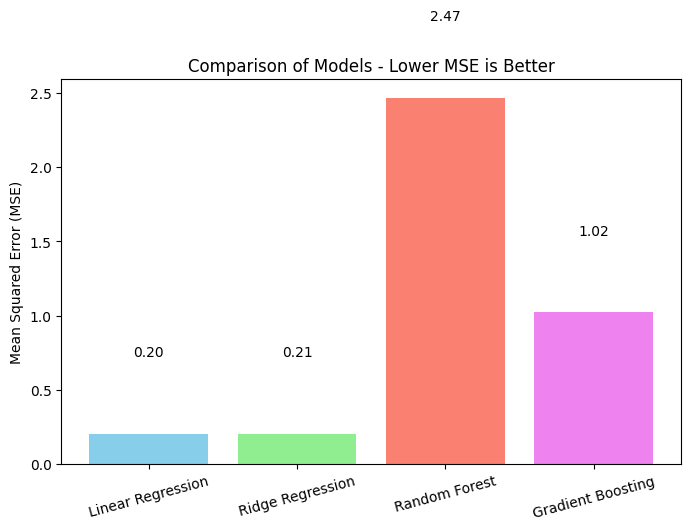

In [4]:
# Graph 1: Visualization: Model Comparison (MSE)
plt.figure(figsize=(8, 5))
plt.bar(results.keys(), results.values(), color=['skyblue', 'lightgreen', 'salmon', 'violet'])
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Comparison of Models - Lower MSE is Better")
plt.xticks(rotation=15)
for i, mse in enumerate(results.values()):
    plt.text(i, mse + 0.5, f"{mse:.2f}", ha='center', va='bottom', fontsize=10)
plt.show()

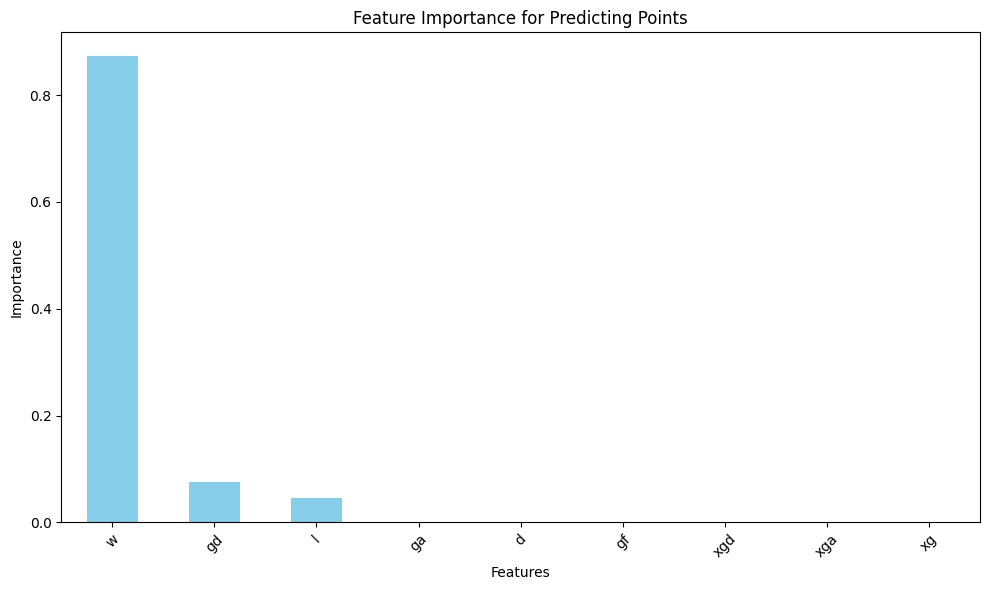

In [5]:
# Graph 2: Feature Importance Bar Chart
rf_model = models["Random Forest"]
importances = rf_model.feature_importances_
feature_importances = pd.Series(importances, index=features).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar', color='skyblue')
plt.title('Feature Importance for Predicting Points')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


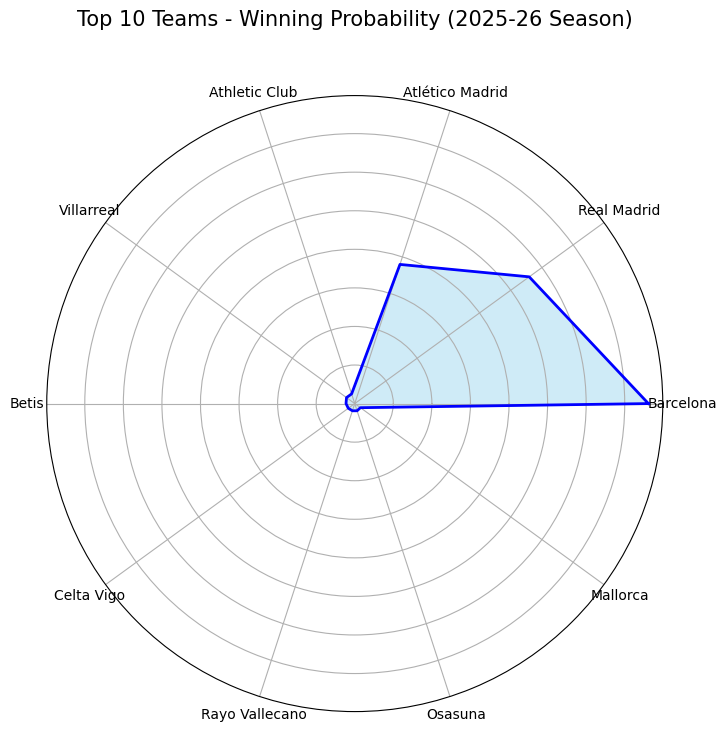

In [6]:
# Graph 3: Winning Probability Spider Chart
labels = top10['squad'].values
stats = top10['Winning Probability'].values
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
stats = np.concatenate((stats, [stats[0]]))
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.fill(angles, stats, color='skyblue', alpha=0.4)
ax.plot(angles, stats, color='blue', linewidth=2)
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
plt.title("Top 10 Teams - Winning Probability (2025-26 Season)", size=15, y=1.1)
plt.show()

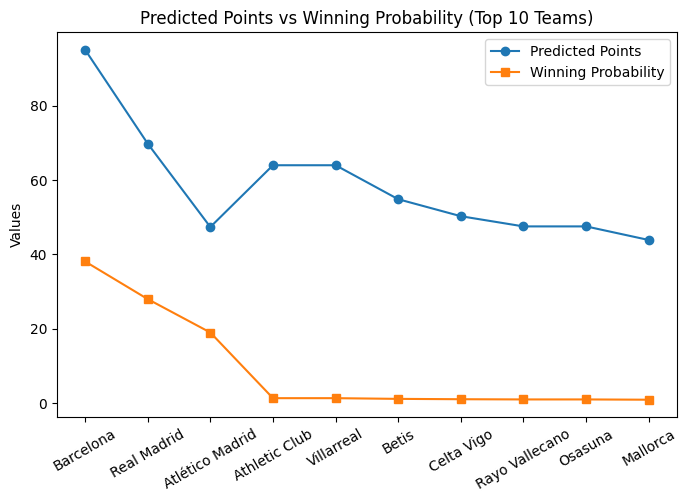

In [7]:
# Graph 4: Predicted Points and Winning Probability

plt.figure(figsize=(8,5))
plt.plot(top10["squad"], top10["Predicted Points"], marker='o', label='Predicted Points')
plt.plot(top10["squad"], top10["Winning Probability"], marker='s', label='Winning Probability')
plt.ylabel("Values")
plt.title("Predicted Points vs Winning Probability (Top 10 Teams)")
plt.xticks(rotation=30)
plt.legend()
plt.show()